In [1]:
import os
import glob
import yaml
import fitsio
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import astropy.io.fits as fits

from desitarget.sv1.sv1_targetmask import desi_mask as sv1_desi_mask
from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask

from desitarget.targetmask import desi_mask, bgs_mask

from astropy.table import Table, vstack, join, unique
from desiutil.dust import mwdust_transmission

##  Generate config files for desispec/scripts/tsnr_ensemble.py

Conveniently generated with e.g.

```papermill tsnr_ensemble.ipynb $CSCRATCH/trash/pm.out -p tracer_type BGS_BRIGHT -p outdir /project/projectdirs/desi/users/mjwilson/tsnr/```

In [42]:
# This cell is tagged parameters. 
# Define main survey tracer type to be studied.
tracer_type   = 'LRG'  # ['BGS_BRIGHT', 'LRG', 'ELG', 'QSO']
outdir        = '/project/projectdirs/desi/users/mjwilson/tsnr/'

In [44]:
# Representative SV1 type for given main survey type. 
sv1_map       = {'BGS_BRIGHT': 'BGS_BRIGHT', 'LRG': 'LRG_IR', 'ELG': 'ELG_FDR_GFIB', 'QSO': 'QSO_RF_4PASS'}

In [3]:
# E.g. https://github.com/desihub/desitarget/blob/dd353c6c8dd8b8737e45771ab903ac30584db6db/py/desitarget/cuts.py#L1434
# Note: LRG is a cut on fiber mag., 
limiting_band = {'BGS': 'r', 'LRG': 'z', 'ELG': 'g', 'QSO': 'r'}

In [4]:
np.random.seed(314)

In [5]:
def imaging_fetch(npix=20, verbose=False):
    '''
    Return a main survey imaging catalog (random stack of size npix healpixels) of a given tracer. 

    input:
        npix: number of healpixels in a random sample to gather.
        verbose:  bool, print debugging 
    '''

    base_type = tracer_type.split('_')[0]
    
    if base_type == 'BGS':
        survey = 'bright'
    else:
        survey = 'dark'
        
    # Fetch the main target catalogues (split by hpx).
    paths=glob.glob('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/targets/main/resolve/{}/targets-{}-hp-*.fits'.format(survey, survey))
            
    if verbose:
        print(len(paths))
            
    # Take a random sample of size hpx, seeded above.
    samples = np.random.choice(paths, size=npix, replace=False)    
    catalog = None
    
    # Fetch the hpx in the sample and stack to a catalog.
    for sample in samples:
        dat = fits.open(sample)[1].data    
    
        if base_type == 'BGS':
            isin = (dat['DESI_TARGET'] & desi_mask['BGS_ANY']) != 0
            isin = isin & ((dat['BGS_TARGET'] & bgs_mask[tracer_type]) != 0)
        
        else:
            isin = (dat['DESI_TARGET'] & desi_mask[tracer_type]) != 0
        
        if verbose:
            print(os.path.basename(sample), np.count_nonzero(isin))
    
        dat = Table(dat[isin])
    
        if catalog is None:
            catalog = dat
        else:
            catalog = vstack((catalog, dat))
            
    print('Compiled {} {} target catalog from {} hpx.'.format(len(catalog), tracer_type, npix))
            
    return catalog

In [29]:
def prod_fetch(prod='blanc', dX2=25., verbose=False):
    '''
    Return a spectroscopic catalog of all SV1 target type in the deep fields in a given prod. 
    Note:  Adds MW_TRANS*
    '''
    
    base_type = tracer_type.split('_')[0]
    
    # Representative SV1 type to map to a main survey type. 
    _tracer_type = sv1_map[tracer_type]
        
    # Fetch the sv1 target catalogues (split by hpx).
    paths=glob.glob('/global/cfs/cdirs/desi/spectro/redux/{}/tiles/*/deep/zbest-*.fits'.format(prod))
    
    if verbose:
        print(len(paths))
    
    catalog = None
    
    # 
    comments = {'80615': 'Missing SV1_DESI_TARGET'}
    ignore   = list(comments.keys())

    # Targeting cols required.
    cols     = ['TARGETID', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'EBV', 'PHOTSYS']
        
    for band in ['G', 'R', 'Z']:
        cols.append('FLUX_{}'.format(band))
        cols.append('FIBERFLUX_{}'.format(band))
    
    # Fetch the hpx in the sample and stack to a catalog.
    for sample in paths:
        zbest = Table.read(sample, 'ZBEST')   
        fmap = Table.read(sample, 'FIBERMAP')

        tileid = os.path.basename(sample).split('-')[2]

        if tileid in ignore:
            print('Ignoring {}'.format(tileid))
            continue

        # Targeting info. for this petal; discarding replicates for N>>1 exp.
        ufmap = unique(fmap, 'TARGETID')
        ufmap = ufmap[cols]
        ufmap['TILEID'] = tileid
        
        assert len(zbest) == len(ufmap)
        
        dat = join(zbest, ufmap, join_type='left', keys='TARGETID')

        try:
            if base_type == 'BGS':
                isin = (dat['SV1_DESI_TARGET'] & sv1_desi_mask['BGS_ANY']) != 0
                isin = isin & ((dat['SV1_BGS_TARGET'] & sv1_bgs_mask[_tracer_type]) != 0)
        
            else:
                isin = (dat['SV1_DESI_TARGET'] & sv1_desi_mask[_tracer_type]) != 0
    
            isin = isin & (dat['ZWARN'] == 0) & (dat['DELTACHI2'] > dX2)    
            
            if verbose:
                print(os.path.basename(sample), len(dat), np.count_nonzero(isin))
            
            dat = dat[isin]
            
        except:
            print('Failed on {}'.format(sample))
            
            dat.pprint()
            
            continue

        for band in ['G', 'R', 'Z']:
            dat['MW_TRANSMISSION_{}'.format(band)] = mwdust_transmission(dat['EBV'], band, dat['PHOTSYS'].data.astype(str))
            
        if catalog is None:
            catalog = dat
        else:
            catalog = vstack((catalog, dat))
            
    print('\nCompiled {}M {} redshift truth catalog from tiles:\n{}.'.format(len(catalog) / 1.e6, _tracer_type, np.unique(catalog['TILEID'].data)))
            
    return  catalog

In [30]:
def target_reduce(dat, config):
    '''
    Inputs:
        dat: Input targeting catalog.    
        config: dictionary to be updated. 
    
    Results:
        Updates config with data derived tsensemble properties. 
    '''
    base_type    = tracer_type.split('_')[0]
    lim_band     = limiting_band[base_type].upper() 
    
    drflx        = dat['FLUX_{}'.format(lim_band)] / dat['MW_TRANSMISSION_{}'.format(lim_band)]
    drfibflx     = dat['FIBERFLUX_{}'.format(lim_band)] / dat['MW_TRANSMISSION_{}'.format(lim_band)]
    
    drmag        = 22.5 - 2.5 * np.log10(drflx)
    drfibmag     = 22.5 - 2.5 * np.log10(drfibflx) 
    
    print('{} Catalog length: {:.1f}M'.format(tracer_type, len(dat) / 1.e6))
    
    med_mag      = np.median(drmag)
    med_fibmag   = np.median(drfibmag)
    
    limit_mag    = np.percentile(drmag, 99.)
    limit_fibmag = np.percentile(drfibmag, 99.)
    
    print('Median mag. in {} band: {:.2f}'.format(lim_band, med_mag))
    print('Median fib. mag. in {} band: {:.2f}'.format(lim_band, med_fibmag))
    
    print('Limiting mag. in {} band: {:.2f}'.format(lim_band, limit_mag))
    print('Limiting fib. mag. in {} band: {:.2f}'.format(lim_band, limit_fibmag))
        
    config['filter'] = 'decam2014-{}'.format(lim_band.lower())
    config['med_mag'] = np.round(med_mag, 3)
    config['limit_mag'] = np.round(limit_mag, 3)
    
    config['med_fibmag'] = np.round(med_fibmag, 3)
    config['limit_fibmag'] = np.round(limit_fibmag, 3)

    # Limit to the 50% faintest targets in reference magnitudes. 
    isin         = (drmag > med_mag) & (drmag < limit_mag)
    dat          = dat[isin]
    
    # Counts of a given morphtype.
    mtypes, cnts = np.unique(dat['MORPHTYPE'], return_counts=True)
    flosses      = []

    for i, mtype in enumerate(mtypes):
        is_type = (dat['MORPHTYPE'] == mtype)
        type_floss = np.median(drfibflx[isin][is_type] / drflx[isin][is_type])

        flosses.append(type_floss)
        
        print('{} fiber flux loss: {:.2f} for {:.2f} fraction'.format(mtype, type_floss, cnts[i] / len(dat)))

        config['{}_frac'.format(mtype.lower())] = cnts[i] / len(dat)
        config['{}_fiberloss'.format(mtype.lower())] = -2.5* np.log10(type_floss)
        
    flosses = np.array(flosses)
    floss = np.average(flosses, weights=cnts)
    
    print('Weighted fiber flux loss: {:.2f}'.format(floss))
    print('Weighted fiber flux loss: {:.2f} mags'.format(-2.5 * np.log10(floss)))
        
    config['wgt_fiberloss'] = np.round(-2.5 * np.log10(floss), 3)
        
    pl.hist(drmag, bins=100)
        
    pl.axvline(med_mag, c='k', lw=0.4)
    pl.axvline(limit_mag, c='k', lw=0.4)

In [31]:
def redshift_reduce(dat, config):
    '''
    Input catalog: dat.    
    '''
    base_type    = tracer_type.split('_')[0]
    lim_band     = limiting_band[base_type].upper() 
    
    drflx        = dat['FLUX_{}'.format(lim_band)] / dat['MW_TRANSMISSION_{}'.format(lim_band)]
    drfibflx     = dat['FIBERFLUX_{}'.format(lim_band)] / dat['MW_TRANSMISSION_{}'.format(lim_band)]
    
    drmag        = 22.5 - 2.5 * np.log10(drflx)
    drfibmag     = 22.5 - 2.5 * np.log10(drfibflx) 
    
    print('{} Catalog length: {:.1f}M'.format(tracer_type, len(dat) / 1.e6))
    
    med_mag      = np.float64(config['med_mag']) 
    limit_mag    = np.float64(config['limit_mag'])
        
    print('Median mag. in {} band: {:.2f}'.format(lim_band, med_mag))
    print('Limiting mag. in {} band: {:.2f}'.format(lim_band, limit_mag))
        
    # Cut to 50% faintest in the respective band.
    isin          = (drmag > med_mag) & (drmag < limit_mag)
    
    dat           = dat[isin]

    zlo           = np.percentile(dat['Z'], 15)
    zhi           = np.percentile(dat['Z'], 85)

    config['zlo'] = np.round(zlo, 3)
    config['zhi'] = np.round(zhi, 3)
        
    pl.hist(dat['Z'], bins=200)
                
    pl.axvline(zlo, c='k', lw=0.4)
    pl.axvline(zhi, c='k', lw=0.4)
            
    pl.xlim(0.0, 2.0)

In [32]:
imaging_catalog = imaging_fetch()

Compiled 455713 LRG target catalog from 20 hpx.


In [33]:
spec_catalog = prod_fetch()

Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615

Compiled 0.003963M LRG_IR redshift truth catalog from tiles:
['80605' '80606' '80607' '80608' '80609' '80610' '80611' '80612' '80613'
 '80614' '80616' '80617' '80618' '80619' '80620' '80621' '80622' '80623'].


In [34]:
config = {'tracer': tracer_type, 'sv1_tracer': sv1_map[tracer_type]}

LRG Catalog length: 0.5M
Median mag. in Z band: 19.81
Median fib. mag. in Z band: 20.81
Limiting mag. in Z band: 21.03
Limiting fib. mag. in Z band: 21.49
DEV fiber flux loss: 0.44 for 0.48 fraction
EXP fiber flux loss: 0.49 for 0.07 fraction
PSF fiber flux loss: 0.78 for 0.03 fraction
REX fiber flux loss: 0.59 for 0.41 fraction
SER fiber flux loss: 0.38 for 0.01 fraction
Weighted fiber flux loss: 0.52
Weighted fiber flux loss: 0.72 mags


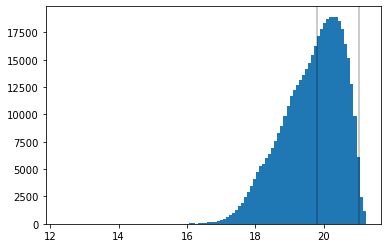

In [35]:
target_reduce(imaging_catalog, config)

In [36]:
config

{'filter': 'decam2014-z',
 'med_mag': 19.81,
 'limit_mag': 21.033,
 'med_fibmag': 20.806,
 'limit_fibmag': 21.488,
 'dev_frac': 0.47571172026493863,
 'dev_fiberloss': 0.8865542709827423,
 'exp_frac': 0.06980837180974218,
 'exp_fiberloss': 0.7718328386545181,
 'psf_frac': 0.034147346359333086,
 'psf_fiberloss': 0.2720675803720951,
 'rex_frac': 0.4068079732374371,
 'rex_fiberloss': 0.5696896091103554,
 'ser_frac': 0.013524588328548973,
 'ser_fiberloss': 1.042807176709175,
 'wgt_fiberloss': 0.716}

LRG Catalog length: 0.0M
Median mag. in Z band: 19.81
Limiting mag. in Z band: 21.03


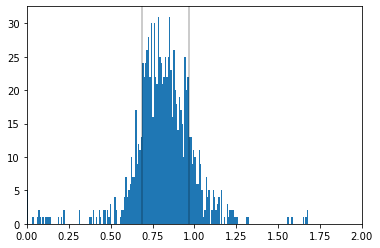

In [37]:
redshift_reduce(spec_catalog, config)

In [38]:
keys = config.keys()

In [39]:
for key in keys:    
    if type(config[key]) != str:
        config[key] = round(float(config[key]), 3)

In [40]:
config

{'filter': 'decam2014-z',
 'med_mag': 19.81,
 'limit_mag': 21.033,
 'med_fibmag': 20.806,
 'limit_fibmag': 21.488,
 'dev_frac': 0.476,
 'dev_fiberloss': 0.887,
 'exp_frac': 0.07,
 'exp_fiberloss': 0.772,
 'psf_frac': 0.034,
 'psf_fiberloss': 0.272,
 'rex_frac': 0.407,
 'rex_fiberloss': 0.57,
 'ser_frac': 0.014,
 'ser_fiberloss': 1.043,
 'wgt_fiberloss': 0.716,
 'zlo': 0.685,
 'zhi': 0.966}

In [41]:
with open(outdir + '/tsnr-config-{}.yaml'.format(tracer_type.lower().split('_')[0]), 'w') as outfile:
    yaml.dump(config, outfile, default_flow_style=False)

## Done